# Homework 1 - Name, SCIPER

In this homework, we're going to build a neural network without using deep learning packages.

Specifically, we're going to build a neural network that annotate cells to cell types in the Pancreas tissue. To do so, we'll need a few building blocks:
- Fully-connected layer, $f(X)=X \cdot W + \vec{b}$
- Nonlinearity layer (ReLU in this homework)
- Loss function (Cross-entropy in this homework)
- Backprop algorithm - a stochastic gradient descent with backpropageted gradients

Reference: 
- https://github.com/yandexdataschool/Practical_DL/tree/fall23
- https://github.com/theislab/scarches-reproducibility

In [1]:
import numpy as np
np.random.seed(42)

## 0. Create the Parent Class 'Layer' (0 pt)

As we learned in the lecture, we need layers that can do both forward pass and backward pass. Here we define the parent class of all layers.

In [2]:
class Layer:

    """
    Each layer performs two things:
    1. Forward pass: Process input to get output: output = layer.forward(input)
    2. Backward pass: Back-propagate gradients through itself: grad_input = layer.backward(input, grad_output)

    The layers that contain learnable parameters also update their parameters during layer.backward.
    """

    def __init__(self):
        """
        Initialize layer parameters.
        """

        # Here we use a dummy layer that does nothing.
        pass

    def forward(self, input):
        """
        Takes input data of shape [batch, input_dims], returns output data [batch, output_dims]
        """

        # Here we use a dummy layer that returns the input.
        return input

    def backward(self, input, grad_output):
        """
        Performs a backpropagation step through the layer.

        We need to apply the chain rule to compute the gradients of the input x:
        d loss / d x  = (d loss / d layer) * (d layer / d x)

        Grad_output provides us d loss / d layer, so we only need to multiply it by d layer / d x.

        Note that if the layer has trainable parameters, we also need to update them using d loss / d layer.
        """

        # The gradient of a dummy layer is grad_output
        return grad_output

## 1. Build layers

We will shortly introduce our dataset's structure in this section, and it should be enough to complete the functions in this section. However, if you find knowing the dataset structure is super helpful to implement the functions of this section, *you can jump to Section 2* and check the dataset structure before going through this section.

### 1.1. Nonlinearity layer - ReLU (1 pt) 

We start from the simplest layer: nonlinearity layer. It simply applies a nonlinearity to each element of your network and it contains no trainable parameter.

Here we implement ReLU. 

Check this link to review ReLU if needed: https://www.v7labs.com/blog/neural-networks-activation-functions

In [3]:
class ReLU(Layer):
    def __init__(self):
        """
        ReLU layer applies elementwise rectified linear to the elements in the inputs.
        There is nothing to initialize in this simple implementation.
        """

        pass

    def forward(self, x):
        """
        Apply elementwise ReLU to the input
        """
        # relu(x) = max(0, x) --> anything below zero is set to 0
        x[x < 0] = 0 
        return x

    def backward(self, input, grad_output):
        """
        Compute the gradient of loss. 
        """
        # We know that:
        # x in (-inf, 0): gradient is 0
        # x in (0, +inf): gradient is 1
        # x = 0: the relu is non-differentiable here, in practice you thus take the
        # gradient of closest point, here we thus set it to 0
        grad_input = (input > 0).astype(int) * grad_output

        return grad_input

### 1.2. Fully-connected Layer (2 pts)

After implementing the simplest layer, we come to a more complicated one: a fully-connected layer. Unlike a nonlinearity layer, a fully-connected layer has trainable parameters.

A fully-connected layer applies an affine transformation. It can be described as: 
$$f(X)= X \cdot W + \vec b ,$$

where
* X is the input of shape [batch_size, input_dims],
* W is a weight matrix [input_dims, output_dims],
* and b is a vector of outputs_dims biases.

W and b are
* initialized when the layer is created,
* and updated each time backward is called.

In [4]:
class Fully_connected(Layer):
    def __init__(self, input_dims, output_dims, learning_rate=0.01):
        """
        Fully_connected layer: f(x) = <x*W> + b
        We initialize W, b, and learning rate to update W and b.
        """
        # Since we are using ReLu as our activation function, it is a common practice to use
        # He weights initialization: sample the weights from the standard normal distribution
        # and then scale them by the sqrt of 2/input_dim
        self.weights = np.random.randn(input_dims, output_dims) * np.sqrt(2.0 / input_dims)
        self.biases = np.zeros(output_dims)
        self.learning_rate = learning_rate

    def forward(self,input):
        """
        Perform f(x) = <x*W> + b .

        input shape: [batch, input_dims]
        output shape: [batch, output_dims]
        """

        output = input @ self.weights + self.biases

        return output

    def backward(self, input, grad_output):
        print(grad_output.shape)
        
        # Compute the gradient of the loss with respect to the layer's parameters
        grad_weights = input.T @ grad_output
        grad_biases = np.sum(grad_output, axis=0)

        # (S)GD step
        self.weights -= self.learning_rate * grad_weights
        self.biases -= self.learning_rate * grad_biases

        # Compute the gradient of the loss with respect to the input
        grad_input = grad_output @ self.weights.T

        return grad_input 

### 1.3. The loss function - softmax cross-entropy (2 pts)

Our model outputs the logits. Since we want to predict probabilities, it would be logical for us to apply softmax nonlinearity to our output logits and compute loss with predicted probabilities.

If you are not familiar with softmax or cross-entropy loss, you can check:
- Softmax: https://en.wikipedia.org/wiki/Softmax_function
- Cross-entropy loss: https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#cross-entropy


(We encourage you to first write down the expression for cross-entropy as a function of softmax logits. You can then try to rewrite it into a more concise form.)

In [5]:
# helper function
def preprocess_final_output(logits, reference_answers):
    # Normalise the logits using softmax
    positive_logits = np.exp(logits)
    rowsum = np.sum(positive_logits, axis=1).reshape(-1, 1)
    softmax_logits = positive_logits / rowsum
    
    # One hot encode the reference answers
    # NB: not a good practice, but for this assignment, seems safe to assume we have 8 classes 
    # Alternatively, I could also compute the number of unuqiue values in the ref answers
    # but in an unlucky batch case, we might end up missing a class, especially for small batch sizes
    # this would be more likely to occur
    K = 8 
    y = np.zeros((logits.shape[0], K))
    y[np.arange(logits.shape[0]), reference_answers] = 1
    
    return y, softmax_logits

def softmax_crossentropy_with_logits(logits, reference_answers):
    """
    Compute cross-entropy loss for each sample from output logits [batch,n_classes] and reference_answers [batch].
    Note that the reference_answers are not one-hot labels. Instead, they are the index of the categories, e.g., 2 instead of [0,0,1].
    The output (xentropy) shape should be [batch,1] or [batch].
    """ 
    # Obtain the one hot encoded y and output of the NN transformed via softmax
    # (each row sums to 1 and thus the values in each row can be interpretted as probabilities)
    y, softmax_logits = preprocess_final_output(logits, reference_answers)
    
    # Compute the cross entropy for each row
    xentropy = -np.sum(y*np.log(softmax_logits), axis=1)
    return xentropy

def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    """
    Compute cross-entropy gradient from output logits [batch,n_classes] and reference_answers [batch].
    Note that the reference_answers are not one-hot labels. Instead, they are the index of the categories, e.g., 2 instead of [0,0,1].
    """
    # Obtain the one hot encoded y and output of the NN transformed via softmax
    # (each row sums to 1 and thus the values in each row can be interpretted as probabilities)
    y, softmax_logits = preprocess_final_output(logits, reference_answers)
    
    # Compute the gradient of the loss with respec to the (raw) logits
    # Then normalise by the batch size n
    n = softmax_logits.shape[0]
    grad_input = (softmax_logits - y) / n

    return grad_input

### 1.4. Network and Forward pass (1 pts)

First, we define network as a list of layers, each applied on top of previous one.

In [6]:
network = []
network.append(Fully_connected(1000, 256))
network.append(ReLU())
network.append(Fully_connected(256, 64))
network.append(ReLU())
network.append(Fully_connected(64, 8))

Here, we implement the forward pass.

In [7]:
def forward(network, X):
    """
    Compute the output of all network layers by applying them sequentially.
    Note that we should return a list of outputs for each layer since we need them for backwrad pass.
    """
    
    outputs = []
    input = X
    
    for l in network:
        input = l.forward(input)
        outputs.append(input)

    return outputs

def predict(network, X):
    """
    Use network to predict the result for each sample. Since we are doing classification, the result should be the index of the most likely class.
    """
    
    # Here we take the output of the last layer and transform it to the positive values
    pos_logits = np.exp(forward(network, X)[-1])
    # Then we take for each row the maximum value and returns its index which corresponds to the class label
    prediction = np.argmax(pos_logits, axis=1)

    return prediction

### 1.5. Train and Backprop (2 pts)

We implement the training function here. The function takes a network, network input X, and ground truth y as the inputs.
When calling this function, we want to have a forward pass and a backward pass.

In [8]:
def train(network,X,y):
    """
    Train your network on a given batch of X and y only once.
    Here are the steps to train once:
    1. Run forward to get all layer outputs.
    2. Estimate loss and loss_grad.
    3. Run layer.backward going from last layer to first.

    Note that after you called backward for all layers, the layers with trainable parameters should have already updated.
    """
    
    # Collect the outputs and inputs for each layer
    layer_outputs = forward(network, X) 
    layer_inputs = [X] + layer_outputs[:-1]
    logits = layer_outputs[-1]
    
    # Compute the loss and its gradient
    loss = softmax_crossentropy_with_logits(logits, y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits, y)
    
    # Run backpropagation
    grad_output = loss_grad
    for i in range(len(network) - 1, -1, -1):
        layer, l_input = network[i], layer_inputs[i]
        grad_output = layer.backward(l_input, grad_output)
    
    return np.mean(loss)

## 2. Test your network (2 pt)

In this homework, we use a single-cell dataset: Pancreas Dataset. Our task is to classify cells to cell types based on the gene expression information. There are 8 different cell types. Cells are samples, genes are features, and cell types are classes.

You need to load the data from '.csv' and implement a simple dataloader. (If you do not remember why we need a dataloader, you can check Exercise 1.)

In [9]:
# Load the features
data = np.loadtxt("data.csv", delimiter=",")

# Load labels
cell_type_per_sample = np.loadtxt("label.csv", dtype=str, delimiter=',')

# Map labels to a number
labels = np.unique(cell_type_per_sample, return_inverse = True)[1]

# Run quick check on shape
print(data.shape, cell_type_per_sample.shape, labels.shape)

(8391, 1000) (8391,) (8391,)


In [10]:
# Setup hyper-parameters
trainf, valf = 0.8, 0.2
n = data.shape[0]

# Compute the sizes of individual datasets
train_n = int(trainf*n)
test_n = n - train_n
print(f"N = {n}, Train: {train_n}, Test: {test_n}")

# Shuffle the data first
ix = np.random.permutation(n)

# Do the split
X_train = data[ix[:train_n], :]
y_train = labels[ix[:train_n]]

X_val = data[ix[train_n:], :]
y_val = labels[ix[train_n:]]

N = 8391, Train: 6712, Test: 1679


Now, we have the training and test data. We need a dataloader.

In [11]:
# A mini-dataloader
from tqdm import trange

# Note: function signatures should remain the same, but the skeleton is just a guide and can be changed.
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    
    assert len(inputs) == len(targets)

    if shuffle:
        indices = np.random.permutation(inputs.shape[0])
    
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            indexs = indices[start_idx : (start_idx + batchsize)]
        else:
            indexs = np.linspace(start_idx, batch_size, endpoint=False)

        yield inputs[indexs], targets[indexs]

Now, test your model! You should get a more than 90% accuracy for training data and a more than 85% accuracy for validation data.

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 168.87it/s]


(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
Epoch 0
Train accuracy: 0.8364123957091776
Val accuracy: 0.8290649195949971


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 186.58it/s]

(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)


Epoch 1
Train accuracy: 0.8682955899880811
Val accuracy: 0.8707564026206075


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 180.56it/s]

(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)


Epoch 2
Train accuracy: 0.8891537544696066
Val accuracy: 0.8868374032162001


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 172.78it/s]

(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)


Epoch 3
Train accuracy: 0.8995828367103695
Val accuracy: 0.8921977367480644


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 148.73it/s]

(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)


Epoch 4
Train accuracy: 0.9025625744934446
Val accuracy: 0.8939845145920191


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 168.16it/s]

(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)


Epoch 5
Train accuracy: 0.9131406436233611
Val accuracy: 0.8975580702799285


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 171.66it/s]

(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)


Epoch 6
Train accuracy: 0.9182061978545888
Val accuracy: 0.9017272185824896


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 172.80it/s]

(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)


Epoch 7
Train accuracy: 0.9250595947556615
Val accuracy: 0.8993448481238833


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 176.49it/s]

(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)


Epoch 8
Train accuracy: 0.9217818831942789
Val accuracy: 0.9023228111971412


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 177.00it/s]

(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)
(256, 8)
(256, 64)
(256, 256)


Epoch 9
Train accuracy: 0.930870083432658
Val accuracy: 0.9041095890410958


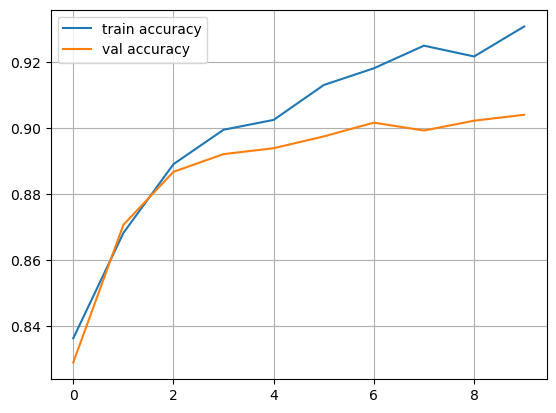

In [12]:
import matplotlib.pyplot as plt

train_log = []
val_log = []

for epoch in range(10):
    for x_batch,y_batch in iterate_minibatches(X_train, y_train, batchsize=256, shuffle=True):
        train(network, x_batch, y_batch)

    train_log.append(np.mean(predict(network, X_train) == y_train))
    val_log.append(np.mean(predict(network, X_val) == y_val))

    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])

plt.plot(train_log,label='train accuracy')
plt.plot(val_log,label='val accuracy')
plt.legend(loc='best')
plt.grid()
plt.show()

---